# Some Examples on Particle Swarm Optimization

### Import packages

In [1]:
import pyswarms as ps
from scipy.optimize import minimize
from pyswarms.utils.search import RandomSearch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from scipy.stats import nbinom

In [2]:
def link(t, k, t0, mu0):
    return 2 * mu0 / (1 + np.exp(-k*(t-t0)))

def likelihood(y, t, k, t0, mu0, phi):
    mut = link(t, k, t0, mu0)
    phi = np.maximum(np.floor(phi), 1)
    p = mut / (mut + phi)
    return nbinom.pmf(y, phi, 1-p)

def pso_obj_fct(b, **kwargs):
    N, d = b.shape
    y, t = kwargs.values()
    
    cost = np.zeros(N)
    for i in range(N):
        k, t0, mu0, phi = b[i, :]
        cost[i] = -np.sum(np.log(likelihood(y, t, k, t0, mu0, phi)))
    
    return cost

def scipy_obj_fct(b, para):
    y, t = para
    
    k, t0, mu0, phi = b
    cost = -np.sum(np.log(likelihood(y, t, k, t0, mu0, phi)))
    
    return cost

In [22]:
parameters = [(np.random.uniform(0, 1, size=400), 6,7,0.4,25),
             (np.random.uniform(0, 1, size=400), 4,-8,0.85,80),
             (np.random.uniform(0, 1, size=400), 1.4, 1.6, 1, 2),
             (np.random.uniform(0, 1, size=100), 6, 7, 0.4, 25),
             (np.random.uniform(0, 1, size=100), 4, -8, 0.85, 80),
             (np.random.uniform(0, 1, size=100), 1.4, 1.6, 1, 2)]
t, mu0, k, t0, phi = parameters[1]
t = np.sort(t)
mut = link(t, k, t0, mu0)
p = mut / (mut + phi)
np.random.seed(1234)
y = nbinom.rvs(phi, 1-p)

n = 100
b = np.random.random((n, 4))
b[:, 2] += 3
x0 = b[:, 0]
#obj_fct(b, y=y, t=t)

In [23]:
# Set-up hyperparameters
options = {'c1': 1.5, 'c2': 0.3, 'w':0.9}
bounds = [tuple([-np.inf, 0, np.min(y), 0]),
          tuple([np.inf, 1, np.max(y) / 2, 100])]
init_pos = b
# Call instance of PSO
gmodel = ps.single.GlobalBestPSO(n_particles=n, dimensions=b.shape[1], options=options, bounds=bounds, init_pos=b)
# Perform optimization
gcost, gbest = gmodel.optimize(pso_obj_fct, iters=100, y=y, t=t)

2021-03-23 12:40:25,447 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 1.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=932  
2021-03-23 12:40:26,861 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 931.9015010959113, best pos: [-9.14708632  0.86262707  3.96164462 95.81741193]


In [24]:
# Set-up hyperparameters
options = {'c1': 1.5,'c2': 0.3,'w': 0.9,'k': 5,'p': 1}

bounds = [tuple([-np.inf, 0, np.min(y), 0]),
          tuple([np.inf, 1, np.max(y) / 2, 100])]
init_pos = b
# Call instance of PSO
lmodel = ps.single.LocalBestPSO(n_particles=n, dimensions=b.shape[1], 
                                   options=options, bounds=bounds, init_pos=b)
# Perform optimization
lcost, lbest = lmodel.optimize(pso_obj_fct, iters=100, y=y, t=t)

2021-03-23 12:40:26,871 - pyswarms.single.local_best - INFO - Optimize for 100 iters with {'c1': 1.5, 'c2': 0.3, 'w': 0.9, 'k': 5, 'p': 1}
pyswarms.single.local_best: 100%|██████████|100/100, best_cost=933   
2021-03-23 12:40:28,282 - pyswarms.single.local_best - INFO - Optimization finished | best cost: 932.7069130111095, best pos: [-9.06899687  0.87272386  3.88373387 57.10485249]


k_g, t_g, mu_g, phi:
 [-8, 0.85, 4, 80]
gbest:
 [-9.1471  0.8626  3.9616 95.8174]
lbest:
 [-9.069   0.8727  3.8837 57.1049]


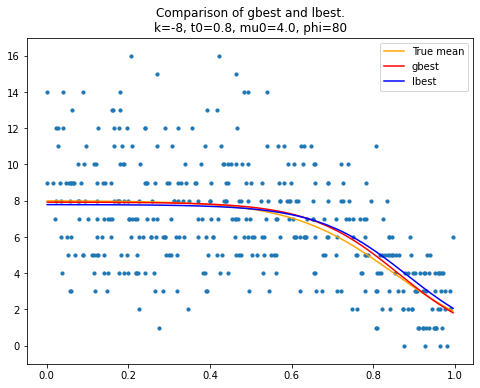

In [25]:
print("k_g, t_g, mu_g, phi:\n", [k, t0, mu0, phi])
print("gbest:\n", np.round(gbest, 4))
print("lbest:\n", np.round(lbest, 4))

plt.figure(figsize=(8,6))
def plot_result(para, color, label):
    
    k_fit, t0_fit, mu0_fit, phi_fit = para
    mut_fit = link(np.sort(t), k_fit, t0_fit, mu0_fit)
    plt.plot(np.sort(t), mut_fit, c=color, label=label)

plt.scatter(t, y, s=10)
plt.plot(t, mut, c='orange', label="True mean")

plot_result(gbest, 'red', label="gbest")
plot_result(lbest+0.01, 'blue', label="lbest")

plt.title("Comparison of gbest and lbest.\n" + 
          "k=%d, t0=%.1f, mu0=%.1f, phi=%d" %(k, t0, mu0, phi))
plt.legend()
plt.ylim(np.min(y)-1, np.max(y)+1)
plt.show()

In [8]:
L_BFGS_B = minimize(scipy_obj_fct, x0=gbest, args=[y+1, t], method='L-BFGS-B')['x']
Nelder_Mead = minimize(scipy_obj_fct, x0=gbest, args=[y+1, t], method='Nelder-Mead')['x']
BFGS = minimize(scipy_obj_fct, x0=gbest, args=[y+1, t], method='BFGS')['x']

k, t0, mu0, phi:
 [7, 0.4, 6, 25]
PSO:
 [ 5.79  0.42  6.15 20.05]
BFGS:
 [ 4.63  0.42  7.03 20.05]
L_BFGS_B:
 [ 4.63  0.42  7.03 20.05]
Nelder-Mead:
 [ 4.65  0.42  7.02 26.27]


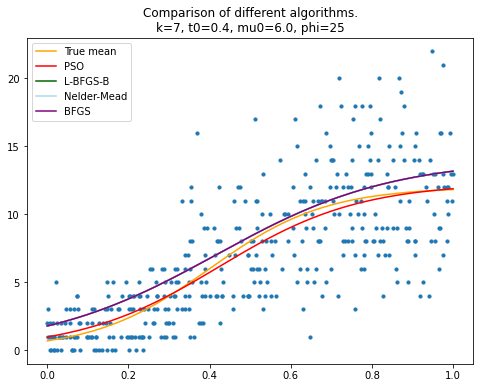

In [11]:
best_pos=gbest
print("k, t0, mu0, phi:\n", [k, t0, mu0, phi])
print("PSO:\n", np.round(best_pos, 2))
print("BFGS:\n", np.round(BFGS, 2))
print("L_BFGS_B:\n", np.round(L_BFGS_B, 2))
print("Nelder-Mead:\n", np.round(Nelder_Mead, 2))

plt.figure(figsize=(8,6))
def plot_result(para, color, label):
    
    k_fit, t0_fit, mu0_fit, phi_fit = para
    mut_fit = link(np.sort(t), k_fit, t0_fit, mu0_fit)
    plt.plot(np.sort(t), mut_fit, c=color, label=label)

plt.scatter(t, y, s=10)
plt.plot(t, mut, c='orange', label="True mean")

plot_result(best_pos, 'red', label="PSO")
plot_result(L_BFGS_B, 'darkgreen', label="L-BFGS-B")
plot_result(Nelder_Mead, 'lightblue', label="Nelder-Mead")
plot_result(BFGS, "purple", label="BFGS")

plt.title("Comparison of different algorithms.\n" + 
          "k=%d, t0=%.1f, mu0=%.1f, phi=%d" %(k, t0, mu0, phi))
plt.legend()
plt.ylim(np.min(y)-1, np.max(y)+1)
plt.show()

# 损失曲面

In [12]:
# Set-up hyperparameters
to_optim = pso_obj_fct

m = 100; n = 100
# k, t0, mu0, phi
xx, yy = np.meshgrid(np.linspace(np.min(y)+1,np.max(y),m), np.linspace(0,80,n))
add1, add2 = np.repeat(k, m*n).reshape(-1, 1), np.repeat(t0, m*n).reshape(-1, 1)
data = np.array((xx, yy)).reshape(2, -1).T
data = np.hstack((add1, add2,data[:, 0].reshape(-1, 1), data[:, 1].reshape(-1, 1)))
z = to_optim(data, y=y, t=t).reshape((n, m))

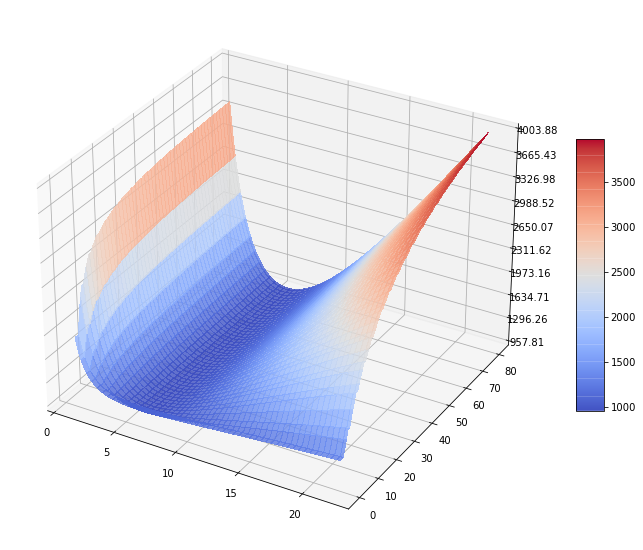

In [16]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12,10))
# Plot the surface.
surf = ax.plot_surface(xx, yy, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha = 0.8)
# Customize the z axis.
#ax.set_zlim(-1.01, -.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')
#ax.view_init(30, 80)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)

plt.show()

# 真实数据应用

In [14]:
import pandas as pd

data = pd.read_csv("test_data.csv").iloc[:, 1:]

t = np.array(np.array(data.iloc[:, 0]))
y = np.floor(np.array(data.iloc[:, 188]))

n = 100
b = np.random.random((n, 4))
b[0, 0] = -10; b[1, 0] = -5; b[2, 0] = 0; b[3, 0] = 5; b[4, 0] = 10
x0 = b[:, 0]

init_pos = b
# Set-up hyperparameters
options = {'c1': 1.6, 'c2': 0.5, 'w':0.9}
bounds = [tuple([-np.inf, np.min(t), np.min(y), 0]),
          tuple([np.inf, np.max(t), np.max(y) / 2, 100])]
# Call instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=n, dimensions=b.shape[1], bounds=bounds, options=options, init_pos=b)
# Perform optimization
best_cost, best_pos = optimizer.optimize(pso_obj_fct, iters=100, y=y, t=t)

2021-03-23 12:23:19,198 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 1.6, 'c2': 0.5, 'w': 0.9}
pyswarms.single.global_best:  64%|██████▍   |64/100, best_cost=500<ipython-input-2-2af2e260ee1b>:17: RuntimeWarning: divide by zero encountered in log
  cost[i] = -np.sum(np.log(likelihood(y, t, k, t0, mu0, phi)))
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=500
2021-03-23 12:23:20,536 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 499.83157740934337, best pos: [1.59514213 0.9987878  1.32193638 1.74454583]


PSO:
 k, t0, mu0, phi
 [1.6  1.   1.32 1.74]


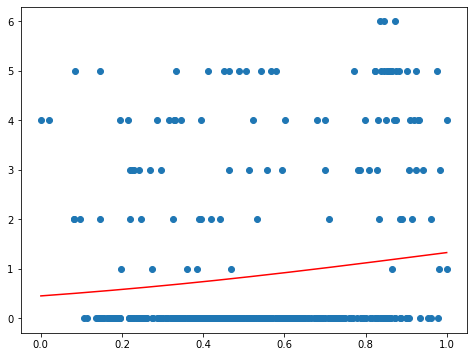

In [15]:
plt.figure(figsize=(8,6))
def plot_result(para, color, label):
    
    k_fit, t0_fit, mu0_fit, phi_fit = para
    mut_fit = link(np.sort(t), k_fit, t0_fit, mu0_fit)
    plt.plot(np.sort(t), mut_fit, c=color, label=label)
plt.scatter(t, y)

plot_result(best_pos, 'red', label="PSO")
print("PSO:\n", "k, t0, mu0, phi\n", np.round(best_pos, 2))